In [1]:
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda:0")

This model will use:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        review = self.df.iloc[index, 0]
        label = self.df.iloc[index, 1]


        return label, review

In [5]:
complete_dataset = CustomDataset(file_path='IMDB Dataset.csv')
print(len(complete_dataset))
print(complete_dataset[1])

50000
('positive', 'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) 

In [6]:
from torch.utils.data.dataset import random_split

train_dataset, test_dataset = random_split(complete_dataset, [25000, 25000])

train_dataset, val_dataset = random_split(train_dataset, [22500, 2500])

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
print("Tokens: ", tokenizer.tokenize("Kevin is great!"))

Tokens:  ['kevin', 'is', 'great', '!']


In [9]:
print(tokenizer.convert_tokens_to_ids(['kevin', 'is', 'great', '!']))

[4901, 2003, 2307, 999]


In [10]:
def str_to_list_nums(str):
    tokens = tokenizer.tokenize(str)
    return tokenizer.convert_tokens_to_ids(tokens)

print(str_to_list_nums('Kevin is great!'))

[4901, 2003, 2307, 999]


In [11]:
# Our model has a sigmoid output, so let's change the labels to 0 for negative and 1 for positive.
def change_label_for_sigmoid(label):
    if label == 'positive':
        return 1.
    else:
        return 0.

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    labels, reviews = list(zip(*batch))

    converted_reviews_batch = [torch.tensor(str_to_list_nums(review)) for review in reviews]
    padded_reviews_batch = pad_sequence(converted_reviews_batch, batch_first=True)

    labels_batch = torch.tensor([change_label_for_sigmoid(label) for label in labels])

    # Unpadded lengths needed for PyTorch to ignore padding during training.
    unpadded_reviews_lengths_batch = torch.tensor([len(converted_review) for converted_review in converted_reviews_batch])

    return padded_reviews_batch, labels_batch, unpadded_reviews_lengths_batch

In [13]:
# Mini-batch Stochastic Gradient Descent.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_dataloader   = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn, drop_last=True)
test_dataloader  = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, drop_last=True)

In [14]:
print("Number of training batches: ", len(train_dataloader))

Number of training batches:  351


In [15]:
from torch.nn.utils.rnn import pack_padded_sequence

class RNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size):
        super(RNN, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.lstm_recurrent_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, reviews, unpadded_reviews_lengths):
        embeddings = self.embedding_layer(reviews)
        # Unpadded lengths needed for PyTorch to ignore padding during training.
        embeddings_packed = pack_padded_sequence(embeddings, unpadded_reviews_lengths.cpu(),
                                               enforce_sorted=False, batch_first=True)
        hidden_states_time_steps, (hidden_state, cell_state) = self.lstm_recurrent_layer(embeddings_packed)
        current_output = self.output_layer(hidden_state)
        sigmoid_output = self.sigmoid(current_output)
        return sigmoid_output

In [16]:
model = RNN(num_embeddings=tokenizer.vocab_size, embedding_dim=256, hidden_size=256).to(device)
print(model)

RNN(
  (embedding_layer): Embedding(30522, 256)
  (lstm_recurrent_layer): LSTM(256, 256, batch_first=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
# BCELoss and NOT CrossEntropyLoss, since we are now doing binary classification (Positive or Negative).
loss_fun = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
epochs = 5

train_losses_average_per_epoch = []
train_accuracies_average_per_epoch = []
val_losses_average_per_epoch = []
val_accuracies_average_per_epoch = []

for current_epoch in range(epochs):

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    for train_padded_reviews_batch, train_labels_batch, train_unpadded_reviews_lengths_batch in train_dataloader:
        train_padded_reviews_batch = train_padded_reviews_batch.to(device)
        train_labels_batch = train_labels_batch.to(device)
        train_unpadded_reviews_lengths_batch = train_unpadded_reviews_lengths_batch.to(device)

        # Forward pass.
        outputs = model(train_padded_reviews_batch, train_unpadded_reviews_lengths_batch).squeeze() # squeeze changes the shape from [1, 64, 1] to [64].
        loss = loss_fun(outputs, train_labels_batch)

        # Backpropagation.
        loss.backward() # Compute gradients.
        optimizer.step() # Update weights.
        optimizer.zero_grad() # Update gradients to 0 for start of next batch.

        # Batch Loss.
        cumulative_loss_current_epoch += loss.item()

        # Batch Accuracy.
        preds = (outputs > 0.5)
        num_correct_preds = (preds == train_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(train_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

    train_loss_average_current_epoch = cumulative_loss_current_epoch / len(train_dataloader)
    train_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(train_dataloader)

    train_losses_average_per_epoch.append(train_loss_average_current_epoch)
    train_accuracies_average_per_epoch.append(train_accuracy_average_current_epoch)

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    with torch.no_grad():
        for val_padded_reviews_batch, val_labels_batch, val_unpadded_reviews_lengths_batch in val_dataloader:
            val_padded_reviews_batch = val_padded_reviews_batch.to(device)
            val_labels_batch = val_labels_batch.to(device)
            val_unpadded_reviews_lengths_batch = val_unpadded_reviews_lengths_batch.to(device)

            outputs = model(val_padded_reviews_batch, val_unpadded_reviews_lengths_batch).squeeze()
            loss = loss_fun(outputs, val_labels_batch)

            # Batch Loss.
            cumulative_loss_current_epoch += loss.item()

            # Batch Accuracy.
            preds = (outputs > 0.5)
            num_correct_preds = (preds == val_labels_batch).sum().item()
            batch_accuracy = num_correct_preds / len(val_labels_batch)
            cumulative_accuracy_current_epoch += batch_accuracy

    val_loss_average_current_epoch = cumulative_loss_current_epoch / len(val_dataloader)
    val_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(val_dataloader)

    val_losses_average_per_epoch.append(val_loss_average_current_epoch)
    val_accuracies_average_per_epoch.append(val_accuracy_average_current_epoch)

    print(
        f'Epoch {current_epoch + 1}  '
        f'Train Loss: {train_losses_average_per_epoch[current_epoch]:.2f} '
        f'Train Accuracy: {train_accuracies_average_per_epoch[current_epoch]:.2f} '
        f'Val Loss: {val_losses_average_per_epoch[current_epoch]:.2f} '
        f'Val Accuracy: {val_accuracies_average_per_epoch[current_epoch]:.2f}'
    )

Token indices sequence length is longer than the specified maximum sequence length for this model (1139 > 512). Running this sequence through the model will result in indexing errors


Epoch 1  Train Loss: 0.66 Train Accuracy: 0.59 Val Loss: 0.55 Val Accuracy: 0.72
Epoch 2  Train Loss: 0.49 Train Accuracy: 0.77 Val Loss: 0.46 Val Accuracy: 0.78
Epoch 3  Train Loss: 0.41 Train Accuracy: 0.82 Val Loss: 0.42 Val Accuracy: 0.81
Epoch 4  Train Loss: 0.36 Train Accuracy: 0.85 Val Loss: 0.40 Val Accuracy: 0.82
Epoch 5  Train Loss: 0.32 Train Accuracy: 0.87 Val Loss: 0.43 Val Accuracy: 0.83


In [19]:
cumulative_accuracy_current_epoch = 0

with torch.no_grad():
    for test_padded_reviews_batch, test_labels_batch, test_unpadded_reviews_lengths_batch in test_dataloader:
        test_padded_reviews_batch = test_padded_reviews_batch.to(device)
        test_labels_batch = test_labels_batch.to(device)
        test_unpadded_reviews_lengths_batch = test_unpadded_reviews_lengths_batch.to(device)

        outputs = model(test_padded_reviews_batch, test_unpadded_reviews_lengths_batch).squeeze()

        # Batch Accuracy.
        preds = (outputs > 0.5)
        num_correct_preds = (preds == test_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(test_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

print(f'Final test accuracy: {cumulative_accuracy_current_epoch / len(test_dataloader):.2%}')

Final test accuracy: 83.92%


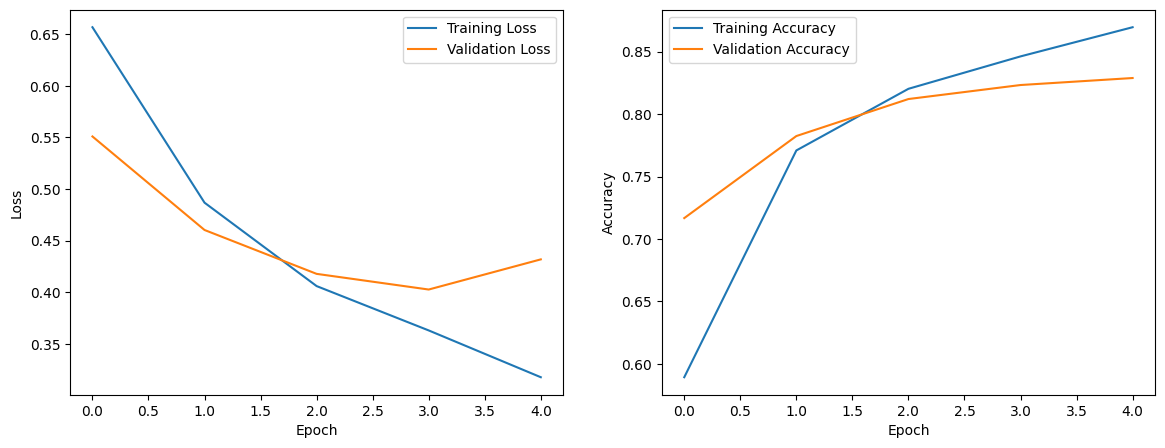

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

metrics = [
    (train_losses_average_per_epoch, val_losses_average_per_epoch, 'Loss'),
    (train_accuracies_average_per_epoch, val_accuracies_average_per_epoch, 'Accuracy')
]

for i, (train_data, val_data, metric_name) in enumerate(metrics):
    ax = axs[i]
    ax.plot(train_data, label='Training ' + metric_name)
    ax.plot(val_data, label='Validation ' + metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

plt.show()

In [21]:
def predict_review(review):
    with torch.no_grad():
        converted_reviews_batch = torch.tensor(str_to_list_nums(review)).unsqueeze(0) # unsqueeze to specify a batch size of 1.
        unpadded_reviews_lengths_batch = torch.tensor([len(converted_review) for converted_review in converted_reviews_batch])

        outputs = model(converted_reviews_batch, unpadded_reviews_lengths_batch)
        return outputs.item()

model.to("cpu")

for review in ["I loved this movie", "I want to see this amazing movie again", "I hated this movie", "I regret watching this movie"]:
    print(f"{review}:\n{predict_review(review)}\n")

I loved this movie:
0.5787197947502136

I want to see this amazing movie again:
0.6179978251457214

I hated this movie:
0.4628269076347351

I regret watching this movie:
0.3967205286026001

